In [396]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Q1 Estimating door size #

In [425]:
def homography_transform(src_pts: np.ndarray, dest_pts: np.ndarray):
    homography_matrix = np.zeros((2*len(src_pts), 9))
    for i in range(len(src_pts)):
        x, y = src_pts[i]
        x_dash, y_dash = dest_pts[i]
        homography_matrix[2*i] = [x, y, 1, 0, 0, 0, -x_dash*x, -x_dash*y, -x_dash]
        homography_matrix[2*i+1] = [0, 0, 0, x, y, 1, -y_dash*x, -y_dash*y, -y_dash]

    eigen_value, eigen_vectors = np.linalg.eig(homography_matrix.T @ homography_matrix)
    min_eigen_val_index = np.argmin(eigen_value)
    return eigen_vectors[:, min_eigen_val_index].reshape(3,3)

test_image = plt.imread('Assignment4/my_image.jpg')

door_corners = np.float32([[308, 648],
                         [424, 2265],
                         [3813, 777],
                         [3771, 1907]])

object_corners = np.float32([[2103, 1361],
                           [2107, 1483],
                           [2374, 1349],
                           [2371, 1468]])

#in mm
object_real_height, object_real_width = 165, 72
door_destination = np.float32([[0,0],[0, 800], [2000, 0],[2000, 800]])

In [426]:
homography_matrix = homography_transform(door_corners, door_destination)
transformed_corners = cv2.perspectiveTransform(object_corners.reshape(1,-1,2), homography_matrix)
w = np.linalg.norm(transformed_corners[0][0] - transformed_corners[0][1])
h = np.linalg.norm(transformed_corners[0][0] - transformed_corners[0][2])

print(f"Object relative width: {w} px, Object relative height: {h} px")

door_abs_width = 800 * w / object_real_width
door_abs_height = 2000 * h / object_real_height
print(f"Door width: {door_abs_width}, Door height: {door_abs_height}")

Object relative width: 71.34793853759766 px, Object relative height: 158.25047302246094 px
Door width: 792.754872639974, Door height: 1918.1875517874053


# Q2 Landscape stitching

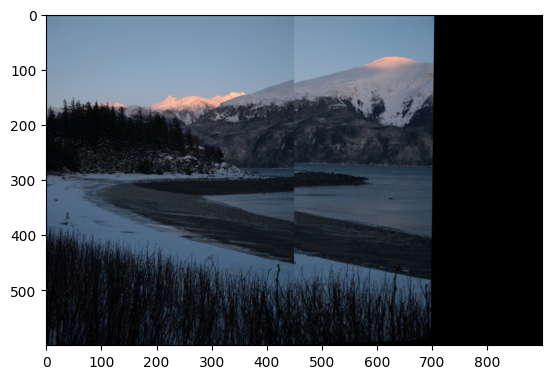

In [427]:
def extract_feature(image: np.ndarray):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    gray_image = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    return keypoints, descriptors


def match_features(descriptors1: np.ndarray, descriptors2: np.ndarray, threshold: float = 0.8):
    """ Matches the features using the ratio of euclidean distance between the closest and second closest keypoint
    """
    matches = []
    for i in range(descriptors1.shape[0]):
        distances = np.linalg.norm(descriptors2 - descriptors1[i], axis=1)
        closest, second_closest = np.argsort(distances)[:2]
        ratio = distances[closest] / distances[second_closest]
        if ratio < threshold:
            matches.append((i, closest, distances[closest]))
    return np.array(matches)


def ransac(landscape_1_keypoints, landscape_2_keypoints, matches, iterations=500, threshold=0.5):
    best_inliers = 0
    best_homography = None
    for _ in range(iterations):
        random_indices = np.random.choice(len(matches), 4)
        src_points = []
        dest_points = []
        for i in random_indices:
            src_points.append(landscape_1_keypoints[int(matches[i][0])].pt)
            dest_points.append(landscape_2_keypoints[int(matches[i][1])].pt)

        src_points = np.float32(src_points)
        dest_points = np.float32(dest_points)

        homography_matrix = homography_transform(src_points, dest_points)

        inliers = 0
        for i, j, _ in matches:
            src_point = landscape_1_keypoints[int(i)].pt
            dest_point = landscape_2_keypoints[int(j)].pt

            src_point = np.float32([src_point[0], src_point[1], 1])
            dest_point = np.float32([dest_point[0], dest_point[1], 1])

            transformed_point = homography_matrix @ src_point
            transformed_point /= transformed_point[2]

            dist = np.linalg.norm(transformed_point[:2] - dest_point[:2])
            if dist < threshold:
                inliers += 1

        if inliers > best_inliers:
            best_inliers = inliers
            best_homography = homography_matrix
    return best_homography


def stitch_images(image1, image2, homography_matrix):
    height, width, _ = image1.shape
    img2_warped = cv2.warpPerspective(image2, homography_matrix, (width, height))
    return np.hstack((image1, img2_warped))


landscape_1 = plt.imread('Assignment4/landscape_1.jpg')
landscape_1_keypoints, landscape_1_descriptors = extract_feature(landscape_1)

landscape_2 = plt.imread('Assignment4/landscape_2.jpg')
landscape_2_keypoints, landscape_2_descriptors = extract_feature(landscape_2)

matches = match_features(landscape_1_descriptors, landscape_2_descriptors)

homography_matrix = ransac(landscape_1_keypoints, landscape_2_keypoints, matches)
panorama = stitch_images(landscape_1, landscape_2, homography_matrix)

plt.imshow(panorama)
plt.show()